# 1- Data Gathering 

In [6]:
#importing required libraries
import pandas as pd
import numpy as np
import tweepy 
import requests
import re
import json
import os
import matplotlib.pyplot as plt
import datetime
import seaborn as sns 
from scipy import stats 
import warnings 
from timeit import default_timer as timer
warnings.filterwarnings('ignore')
%matplotlib inline 

### Dowenload Twitter Archive Manually 

In [7]:
archive_df =pd.read_csv('twitter-archive-enhanced.csv')

### Dowenload Image_Predictions Programmatically

In [8]:
if not os.path.isfile('image-predictions.tsv'):
    url='https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
    r = requests.get(url)
    with open('image-predictions.tsv', 'wb') as local_file:
        local_file.write(r.content)

In [9]:
image_predictions_df =pd.read_csv('image-predictions.tsv',sep='\t')

### Dowenload Twitter API Data 

In [10]:
#Checking the code 

consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'


auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

exp_tweet = api.get_status(archive_df.tweet_id[1000], tweet_mode = 'extended')
test = exp_tweet._json
print(test)


TweepError: [{'code': 89, 'message': 'Invalid or expired token.'}]

In [ ]:
test.keys()

In [ ]:
test['user']['followers_count']

In [ ]:
#create Json txt

tweet_ids = archive_df.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
if not os.path.isfile('tweet_json.txt'):
    with open('tweet_json.txt', 'w') as outfile:
        # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
        for tweet_id in tweet_ids:
            count += 1
            print(str(count) + ": " + str(tweet_id))
            try:
                tweet = api.get_status(tweet_id, tweet_mode='extended')
                print("Success")
                json.dump(tweet._json, outfile)
                outfile.write('\n')
            except tweepy.TweepError as e:
                print("Fail")
                fails_dict[tweet_id] = e
                pass
end = timer()
print(end - start)
print(fails_dict)


In [ ]:
fails_dict

In [11]:
#Create the Api data frame from Json file considering only (favorite_count and retweet_count)
df_list = []
with open('tweet_json.txt', encoding='utf-8') as file:
    for line in file:
        tweet= json.loads(line)
        df_list.append(tweet)
        
api_df= pd.DataFrame(df_list)
api_df =api_df[['id','favorite_count','retweet_count']]

# 2- Data Assessing

### `archive_df` table

In [12]:
archive_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [13]:
archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [14]:
archive_df.shape

(2356, 17)

In [15]:
archive_df.tweet_id.duplicated().sum()

0

In [16]:
archive_df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [17]:
archive_df[archive_df.expanded_urls.isnull() == True]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is res...,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Jack_Septic_Eye I'd need a few more pics to p...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
179,857214891891077121,8.571567e+17,1.806710e+08,2017-04-26 12:48:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Marc_IRL pixelated af 12/10,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
185,856330835276025856,NaN,NaN,2017-04-24 02:15:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Jenna_Marbles: @dog_rates Thanks for ratin...,8.563302e+17,66699013.0,2017-04-24 02:13:14 +0000,NaN,14,10,None,None,None,None,None
186,856288084350160898,8.562860e+17,2.792810e+08,2017-04-23 23:26:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@xianmcguire @Jenna_Marbles Kardashians wouldn...,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@dhmontgomery We also gave snoop dogg a 420/10...,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None
189,855860136149123072,8.558585e+17,1.361572e+07,2017-04-22 19:05:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@s8n You tried very hard to portray this good ...,NaN,NaN,NaN,NaN,666,10,None,None,None,None,None


##### `rating_numerator` and `rating_denominator` max values are looks wired

In [18]:
archive_df.rating_numerator.value_counts()
# there are high values 

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [19]:
archive_df.rating_denominator.value_counts()
# Not all values equal to 10

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [20]:
archive_df.name.value_counts()

None       745
a           55
Charlie     12
Cooper      11
Oliver      11
          ... 
Ziva         1
Brandy       1
Emmie        1
Ruffles      1
Theo         1
Name: name, Length: 957, dtype: int64

In [21]:
wired_name =[]
for name in archive_df.name:
    if name.islower():
        wired_name.append(name)
print(wired_name)         

['such', 'a', 'quite', 'quite', 'quite', 'not', 'one', 'incredibly', 'a', 'mad', 'an', 'very', 'a', 'very', 'just', 'my', 'one', 'not', 'his', 'one', 'a', 'a', 'a', 'an', 'very', 'actually', 'a', 'just', 'getting', 'mad', 'very', 'this', 'unacceptable', 'all', 'a', 'old', 'a', 'infuriating', 'a', 'a', 'a', 'an', 'a', 'a', 'very', 'getting', 'just', 'a', 'the', 'the', 'actually', 'by', 'a', 'officially', 'a', 'the', 'the', 'a', 'a', 'a', 'a', 'life', 'a', 'one', 'a', 'a', 'a', 'light', 'just', 'space', 'a', 'the', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'an', 'a', 'the', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'quite', 'a', 'an', 'a', 'an', 'the', 'the', 'a', 'a', 'an', 'a', 'a', 'a', 'a']


### `image_predictions_df` table

In [22]:
image_predictions_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [23]:
image_predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [24]:
image_predictions_df.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [25]:
image_predictions_df[(image_predictions_df.p1_dog == False) & (image_predictions_df.p2_dog == False) & (image_predictions_df.p3_dog == False)]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
17,666104133288665088,https://pbs.twimg.com/media/CT56LSZWoAAlJj2.jpg,1,hen,0.965932,False,cock,0.033919,False,partridge,0.000052,False
18,666268910803644416,https://pbs.twimg.com/media/CT8QCd1WEAADXws.jpg,1,desktop_computer,0.086502,False,desk,0.085547,False,bookcase,0.079480,False
21,666293911632134144,https://pbs.twimg.com/media/CT8mx7KW4AEQu8N.jpg,1,three-toed_sloth,0.914671,False,otter,0.015250,False,great_grey_owl,0.013207,False
25,666362758909284353,https://pbs.twimg.com/media/CT9lXGsUcAAyUFt.jpg,1,guinea_pig,0.996496,False,skunk,0.002402,False,hamster,0.000461,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2021,880935762899988482,https://pbs.twimg.com/media/DDm2Z5aXUAEDS2u.jpg,1,street_sign,0.251801,False,umbrella,0.115123,False,traffic_light,0.069534,False
2022,881268444196462592,https://pbs.twimg.com/media/DDrk-f9WAAI-WQv.jpg,1,tusker,0.473303,False,Indian_elephant,0.245646,False,ibex,0.055661,False
2046,886680336477933568,https://pbs.twimg.com/media/DE4fEDzWAAAyHMM.jpg,1,convertible,0.738995,False,sports_car,0.139952,False,car_wheel,0.044173,False
2052,887517139158093824,https://pbs.twimg.com/ext_tw_video_thumb/88751...,1,limousine,0.130432,False,tow_truck,0.029175,False,shopping_cart,0.026321,False


In [26]:
image_predictions_df[(image_predictions_df.p1_dog == True) & (image_predictions_df.p2_dog == False) & (image_predictions_df.p3_dog == False)]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
34,666435652385423360,https://pbs.twimg.com/media/CT-nsTQWEAEkyDn.jpg,1,Chesapeake_Bay_retriever,0.184130,True,chain_saw,0.056775,False,power_drill,3.676340e-02,False
82,667491009379606528,https://pbs.twimg.com/media/CUNniSlUYAEj1Jl.jpg,1,borzoi,0.852088,True,ice_bear,0.132264,False,weasel,5.729980e-03,False
83,667495797102141441,https://pbs.twimg.com/media/CUNr4-7UwAAg2lq.jpg,1,Chihuahua,0.143957,True,Christmas_stocking,0.118651,False,ski_mask,9.248170e-02,False
119,668171859951755264,https://pbs.twimg.com/media/CUXSwy8W4AA6uet.jpg,1,Chihuahua,0.664834,True,cowboy_boot,0.060343,False,giant_panda,5.983750e-02,False
149,668636665813057536,https://pbs.twimg.com/media/CUd5gBGWwAA0IVA.jpg,1,komondor,0.999956,True,llama,0.000043,False,ram,2.160900e-07,False
234,670421925039075328,https://pbs.twimg.com/media/CU3RLqfW4AE0pbA.jpg,1,Chihuahua,0.275793,True,corn,0.073596,False,bolete,5.490510e-02,False
258,670780561024270336,https://pbs.twimg.com/media/CU8XW2dWwAA-Lmc.jpg,1,Labrador_retriever,0.244889,True,American_black_bear,0.056994,False,brown_bear,5.399260e-02,False
320,671789708968640512,https://pbs.twimg.com/tweet_video_thumb/CVKtH-...,1,dalmatian,0.114259,True,teddy,0.062275,False,steam_locomotive,4.970020e-02,False
332,672139350159835138,https://pbs.twimg.com/media/CVPrLE2WwAELCxD.jpg,1,Rottweiler,0.290992,True,American_black_bear,0.238120,False,chimpanzee,1.155410e-01,False
422,674051556661161984,https://pbs.twimg.com/media/CVq2UHwWEAAduMw.jpg,1,Shih-Tzu,0.179777,True,badger,0.160580,False,three-toed_sloth,1.321540e-01,False


### `api_df` table

In [27]:
api_df.head()

,id,favorite_count,retweet_count
0,892420643555336193,35730,7551
1,892177421306343426,30873,5599
2,891815181378084864,23216,3708
3,891689557279858688,39021,7736
4,891327558926688256,37277,8335


In [28]:
api_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   id              2331 non-null   int64
 1   favorite_count  2331 non-null   int64
 2   retweet_count   2331 non-null   int64
dtypes: int64(3)
memory usage: 54.8 KB


In [29]:
api_df.duplicated().sum()

0

In [30]:
api_df.describe()

,id,favorite_count,retweet_count
count,2.331000e+03,2331.000000,2331.000000
mean,7.419079e+17,7463.335478,2655.429000
std,6.823170e+16,11588.357253,4491.217169
min,6.660209e+17,0.000000,1.000000
25%,6.782670e+17,1298.500000,539.000000
50%,7.182469e+17,3243.000000,1243.000000
75%,7.986692e+17,9141.500000,3083.500000
max,8.924206e+17,154030.000000,76315.000000


#### Quality aspects:
#### I will use data quality dimensions to guide me through process while assessing (Completeness, Validity, Accuracy, Consistency)
##### `archive_df` table
- tweet_id column should be string not int.
- Timestamp is an object not a Datetime.
- Tweets without expanded URL should be drop.
- All retweeted tweets should be drop. 
- Some rating_denominator values are not equal to 10 as it's should be.
- Some rating_numerator values are too high values like (1776, etc.) need investigation.
- Some Dog names are not correct extracted from the text.
- There is a `None` value in the last 5 columns.
- Some Doges are not classified and some other classified two times.
- We should change Dog_Stage type to category.
- Tweets without image should be dropped.

##### `image_predictions_df` table
- In case all predications are false then these pictures are not for dogs, so we can drop them.
- Columns name not descriptive so I will replace them
- Some names in P1 ,P2 & P3 lower  case or has _ in between 

##### `api_df` table
- Id column name should be match `archive_df`
- Id column should be string not int.


#### Tidiness
- Drop unnecessary columns
- `archive_df` we can combine doggo, floofer, pupper, puppo coulmns in one column as Dog_Stage 
- `image_predictions_df` P1, P1_con, P1_dog are repeated three times we need to make it in one coulmn.
- The Three Data frames need to be merged.  



# Cleaning

In [31]:
archive_df_clean = archive_df.copy()
image_predictions_df_clean = image_predictions_df.copy()
api_df_clean = api_df.copy()

#### `archive_df_clean` table
##### Define
- tweet_id column should be string not int.

##### Code

In [32]:
archive_df_clean.tweet_id = archive_df_clean.tweet_id.astype(str)

##### Test

In [33]:
archive_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   object 
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

##### Define
- Timestamp  is a an object not a Datetime.

##### Code

In [34]:
archive_df_clean['timestamp'] = archive_df_clean['timestamp'].str.slice(start=0, stop=-6)
archive_df_clean['timestamp'] = pd.to_datetime(archive_df_clean['timestamp'], format = "%Y-%m-%d %H:%M:%S")

##### Test

In [35]:
archive_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   tweet_id                    2356 non-null   object        
 1   in_reply_to_status_id       78 non-null     float64       
 2   in_reply_to_user_id         78 non-null     float64       
 3   timestamp                   2356 non-null   datetime64[ns]
 4   source                      2356 non-null   object        
 5   text                        2356 non-null   object        
 6   retweeted_status_id         181 non-null    float64       
 7   retweeted_status_user_id    181 non-null    float64       
 8   retweeted_status_timestamp  181 non-null    object        
 9   expanded_urls               2297 non-null   object        
 10  rating_numerator            2356 non-null   int64         
 11  rating_denominator          2356 non-null   int64       

In [36]:
archive_df_clean.timestamp.head()

0   2017-08-01 16:23:56
1   2017-08-01 00:17:27
2   2017-07-31 00:18:03
3   2017-07-30 15:58:51
4   2017-07-29 16:00:24
Name: timestamp, dtype: datetime64[ns]

##### Define
- Tweets without expanded URL should be drop.

##### Code

In [37]:
archive_df_clean = archive_df_clean[archive_df_clean['expanded_urls'].notna()]

##### Test

In [38]:
archive_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2297 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   tweet_id                    2297 non-null   object        
 1   in_reply_to_status_id       23 non-null     float64       
 2   in_reply_to_user_id         23 non-null     float64       
 3   timestamp                   2297 non-null   datetime64[ns]
 4   source                      2297 non-null   object        
 5   text                        2297 non-null   object        
 6   retweeted_status_id         180 non-null    float64       
 7   retweeted_status_user_id    180 non-null    float64       
 8   retweeted_status_timestamp  180 non-null    object        
 9   expanded_urls               2297 non-null   object        
 10  rating_numerator            2297 non-null   int64         
 11  rating_denominator          2297 non-null   int64       

##### Define
- All retweeted tweets should be drop. 

##### Code

In [39]:
archive_df_clean[archive_df_clean['retweeted_status_id'].notnull()==True]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Canela. She attempted s...,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,https://twitter.com/dog_rates/status/887473957...,13,10,Canela,None,None,None,None
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48,"<a href=""http://twitter.com/download/iphone"" r...",RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,8.860537e+17,1.960740e+07,2017-07-15 02:44:07 +0000,https://twitter.com/dog_rates/status/886053434...,12,10,None,None,None,None,None
36,885311592912609280,NaN,NaN,2017-07-13 01:35:06,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Lilly. She just paralle...,8.305833e+17,4.196984e+09,2017-02-12 01:04:29 +0000,https://twitter.com/dog_rates/status/830583320...,13,10,Lilly,None,None,None,None
68,879130579576475649,NaN,NaN,2017-06-26 00:13:58,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Emmy. She was adopted t...,8.780576e+17,4.196984e+09,2017-06-23 01:10:23 +0000,https://twitter.com/dog_rates/status/878057613...,14,10,Emmy,None,None,None,None
73,878404777348136964,NaN,NaN,2017-06-24 00:09:53,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Shadow. In an attempt to r...,8.782815e+17,4.196984e+09,2017-06-23 16:00:04 +0000,"https://www.gofundme.com/3yd6y1c,https://twitt...",13,10,Shadow,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1023,746521445350707200,NaN,NaN,2016-06-25 01:52:36,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Shaggy. He knows exactl...,6.678667e+17,4.196984e+09,2015-11-21 00:46:50 +0000,https://twitter.com/dog_rates/status/667866724...,10,10,Shaggy,None,None,None,None
1043,743835915802583040,NaN,NaN,2016-06-17 16:01:16,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Extremely intelligent dog here....,6.671383e+17,4.196984e+09,2015-11-19 00:32:12 +0000,https://twitter.com/dog_rates/status/667138269...,10,10,None,None,None,None,None
1242,711998809858043904,NaN,NaN,2016-03-21 19:31:59,"<a href=""http://twitter.com/download/iphone"" r...",RT @twitter: @dog_rates Awesome Tweet! 12/10. ...,7.119983e+17,7.832140e+05,2016-03-21 19:29:52 +0000,https://twitter.com/twitter/status/71199827977...,12,10,None,None,None,None,None
2259,667550904950915073,NaN,NaN,2015-11-20 03:51:52,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",RT @dogratingrating: Exceptional talent. Origi...,6.675487e+17,4.296832e+09,2015-11-20 03:43:06 +0000,https://twitter.com/dogratingrating/status/667...,12,10,None,None,None,None,None


In [40]:
archive_df_clean.drop(archive_df_clean[archive_df_clean['retweeted_status_id'].notnull()==True].index, inplace=True)
archive_df_clean.drop(archive_df_clean[archive_df_clean['in_reply_to_status_id'].notnull()==True].index, inplace=True)

##### Test

In [41]:
archive_df_clean[archive_df_clean['retweeted_status_id'].notnull()==True]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [42]:
archive_df_clean[archive_df_clean['retweeted_status_user_id'].notnull()==True]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [43]:
archive_df_clean[archive_df_clean['in_reply_to_user_id'].notnull()==True]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


##### Define
- Drop unnessary columns

##### Code

In [44]:
archive_df_clean = archive_df_clean.drop(['in_reply_to_user_id','retweeted_status_user_id','retweeted_status_id',
                                          'retweeted_status_timestamp','in_reply_to_status_id'], axis=1)

##### Test

In [45]:
archive_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            2094 non-null   object        
 1   timestamp           2094 non-null   datetime64[ns]
 2   source              2094 non-null   object        
 3   text                2094 non-null   object        
 4   expanded_urls       2094 non-null   object        
 5   rating_numerator    2094 non-null   int64         
 6   rating_denominator  2094 non-null   int64         
 7   name                2094 non-null   object        
 8   doggo               2094 non-null   object        
 9   floofer             2094 non-null   object        
 10  pupper              2094 non-null   object        
 11  puppo               2094 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(9)
memory usage: 212.7+ KB


##### Define
- Now I will work on doggo,floofer,pupper,puppo columns 

##### Code


In [46]:
(archive_df_clean.loc[:, 'doggo':"puppo"] != 'None') .sum()

doggo       83
floofer     10
pupper     229
puppo       24
dtype: int64

In [47]:
stage_n = archive_df_clean[(archive_df_clean['doggo'] != 'None') & (archive_df_clean['pupper'] != 'None')]

In [48]:
stage_n.iloc[:, -4:].head()

,doggo,floofer,pupper,puppo
460,doggo,None,pupper,None
531,doggo,None,pupper,None
575,doggo,None,pupper,None
705,doggo,None,pupper,None
733,doggo,None,pupper,None


In [49]:
# Replace all none values with space 
archive_df_clean[['doggo', 'floofer', 'pupper', 'puppo']] = archive_df_clean[['doggo', 'floofer', 'pupper', 'puppo']].replace('None', '')

In [50]:
#concatenate them
archive_df_clean['dog_stage'] = archive_df_clean['doggo'] + archive_df_clean['floofer'] + archive_df_clean['pupper'] + archive_df_clean['puppo']

In [51]:
archive_df_clean = archive_df_clean.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1)

##### Test

In [52]:
archive_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 0 to 2355
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            2094 non-null   object        
 1   timestamp           2094 non-null   datetime64[ns]
 2   source              2094 non-null   object        
 3   text                2094 non-null   object        
 4   expanded_urls       2094 non-null   object        
 5   rating_numerator    2094 non-null   int64         
 6   rating_denominator  2094 non-null   int64         
 7   name                2094 non-null   object        
 8   dog_stage           2094 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(6)
memory usage: 163.6+ KB


In [53]:
archive_df_clean.sample(30)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage
233,847842811428974592,2017-03-31 16:07:33,"<a href=""http://twitter.com/download/iphone"" r...","This is Rontu. He is described as a pal, cuddl...","https://www.gofundme.com/help-save-rontu,https...",12,10,Rontu,
1789,677547928504967168,2015-12-17 17:56:29,"<a href=""http://twitter.com/download/iphone"" r...",Not much to say here. I just think everyone ne...,https://twitter.com/dog_rates/status/677547928...,12,10,None,
1706,680805554198020098,2015-12-26 17:41:07,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",This guy's dog broke. So sad. 9/10 would still...,https://vine.co/v/iAP0Ugzi2PO,9,10,None,
2342,666082916733198337,2015-11-16 02:38:37,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a well-established sunblockerspan...,https://twitter.com/dog_rates/status/666082916...,6,10,None,
252,844973813909606400,2017-03-23 18:07:10,"<a href=""http://twitter.com/download/iphone"" r...",This is Brady. He's a recovering alcoholic. De...,https://twitter.com/dog_rates/status/844973813...,12,10,Brady,
349,831650051525054464,2017-02-14 23:43:18,"<a href=""http://twitter.com/download/iphone"" r...","I usually only share these on Friday's, but th...","http://www.gofundme.com/bluethewhitehusky,http...",13,10,None,
1537,689877686181715968,2016-01-20 18:30:32,"<a href=""http://twitter.com/download/iphone"" r...",This is Durg. He's trying to conquer his fear ...,https://twitter.com/dog_rates/status/689877686...,9,10,Durg,
1503,692017291282812928,2016-01-26 16:12:33,"<a href=""http://twitter.com/download/iphone"" r...",This is Kingsley Wellensworth III. He owns 7 r...,https://twitter.com/dog_rates/status/692017291...,9,10,Kingsley,
1870,675149409102012420,2015-12-11 03:05:37,"<a href=""http://twitter.com/download/iphone"" r...",holy shit 12/10 https://t.co/p6O8X93bTQ,https://twitter.com/dog_rates/status/675149409...,12,10,None,
520,810254108431155201,2016-12-17 22:43:27,"<a href=""http://twitter.com/download/iphone"" r...","This is Gus. He likes to be close to you, whic...",https://twitter.com/dog_rates/status/810254108...,12,10,Gus,


In [54]:
archive_df_clean.dog_stage.value_counts()

                1759
pupper           220
doggo             72
puppo             23
doggopupper        9
floofer            9
doggopuppo         1
doggofloofer       1
Name: dog_stage, dtype: int64

In [55]:
archive_df_clean.dog_stage = archive_df_clean.dog_stage.replace('doggopupper', 'doggo-pupper')
archive_df_clean.dog_stage = archive_df_clean.dog_stage.replace('doggopuppo', 'doggo-puppo')
archive_df_clean.dog_stage = archive_df_clean.dog_stage.replace('doggofloofer', 'doggo-floofer')

In [56]:
archive_df_clean.dog_stage.value_counts()

                 1759
pupper            220
doggo              72
puppo              23
doggo-pupper        9
floofer             9
doggo-floofer       1
doggo-puppo         1
Name: dog_stage, dtype: int64

#### Define
- Some Dog names are not correct extracted from the text.

##### Code

In [57]:
#check lower case values 
archive_df_clean[archive_df_clean.name.str.islower() == True].name.value_counts()

a               55
the              8
an               6
one              4
very             4
quite            3
just             3
not              2
getting          2
actually         2
space            1
my               1
by               1
unacceptable     1
his              1
life             1
mad              1
old              1
officially       1
all              1
infuriating      1
light            1
such             1
this             1
incredibly       1
Name: name, dtype: int64

In [58]:
#Replace all lower case values with None 
archive_df_clean['name'][archive_df_clean['name'].str.match('[a-z]+')] = 'None'

In [59]:
#Check 
archive_df_clean[archive_df_clean.name.str.islower() == True].name.value_counts()

Series([], Name: name, dtype: int64)

In [60]:
#Replace all None with NAN
archive_df_clean['name'][archive_df_clean['name'].str.match('None')] = np.nan

In [61]:
#Check
archive_df_clean.name.value_counts().sample(30)

Aldrick     1
Bernie      2
Flurpson    1
Patch       1
Grady       1
Archie      4
Ebby        1
Eazy        1
Ozzie       1
Lipton      1
Herald      2
Percy       2
Marley      2
Keet        1
Maximus     3
Nollie      1
Marq        1
Aja         1
Kane        1
Hunter      2
Harold      2
Yoda        1
Bloop       1
Baxter      2
Rolf        1
Stormy      1
Izzy        1
Trip        1
Theodore    2
Cassie      4
Name: name, dtype: int64

#### `image_predictions_df_clean` table
##### Define
- In case all predications are false then these pictures are not for dogs, so we can drop them.

##### Code

In [62]:
image_predictions_df_clean.drop(image_predictions_df_clean[(image_predictions_df_clean.p1_dog == False) & (image_predictions_df_clean.p2_dog == False) & (image_predictions_df_clean.p3_dog == False)].index, inplace=True)

##### Test

In [63]:
image_predictions_df_clean[(image_predictions_df_clean.p1_dog == False) & (image_predictions_df_clean.p2_dog == False) & (image_predictions_df_clean.p3_dog == False)]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


##### Define
- Columns name not descriptive so I will replace them

In [64]:
image_predictions_df_clean.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


##### Code

In [65]:
# Renaming the dataset columns
new_col = ['tweet_id', 'jpg_url', 'img_num', 
       'breed_1','prediction_1', 'confidence_1',
       'breed_2','prediction_2', 'confidence_2',
       'breed_3','prediction_3', 'confidence_3',]
image_predictions_df_clean.columns = new_col

##### Test

In [66]:
image_predictions_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1751 entries, 0 to 2073
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   tweet_id      1751 non-null   int64  
 1   jpg_url       1751 non-null   object 
 2   img_num       1751 non-null   int64  
 3   breed_1       1751 non-null   object 
 4   prediction_1  1751 non-null   float64
 5   confidence_1  1751 non-null   bool   
 6   breed_2       1751 non-null   object 
 7   prediction_2  1751 non-null   float64
 8   confidence_2  1751 non-null   bool   
 9   breed_3       1751 non-null   object 
 10  prediction_3  1751 non-null   float64
 11  confidence_3  1751 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 141.9+ KB


##### Define
- some names in P1 ,P2 & P3 lower  case or has _ in between 


##### Code

In [67]:
image_predictions_df_clean.breed_1 = image_predictions_df_clean.breed_1.str.replace('_', ' ').str.capitalize()
image_predictions_df_clean.breed_2 = image_predictions_df_clean.breed_2.str.replace('_', ' ').str.capitalize()
image_predictions_df_clean.breed_3 = image_predictions_df_clean.breed_3.str.replace('_', ' ').str.capitalize()

##### Test

In [68]:
image_predictions_df_clean.head(20)

,tweet_id,jpg_url,img_num,breed_1,prediction_1,confidence_1,breed_2,prediction_2,confidence_2,breed_3,prediction_3,confidence_3
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh springer spaniel,0.465074,True,Collie,0.156665,True,Shetland sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,Redbone,0.506826,True,Miniature pinscher,0.074192,True,Rhodesian ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German shepherd,0.596461,True,Malinois,0.138584,True,Bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian ridgeback,0.408143,True,Redbone,0.360687,True,Miniature pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,Miniature pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese mountain dog,0.651137,True,English springer,0.263788,True,Greater swiss mountain dog,0.016199,True
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,Chow,0.692517,True,Tibetan mastiff,0.058279,True,Fur coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,Shopping cart,0.962465,False,Shopping basket,0.014594,False,Golden retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,Miniature poodle,0.201493,True,Komondor,0.192305,True,Soft-coated wheaten terrier,0.082086,True
10,666063827256086533,https://pbs.twimg.com/media/CT5Vg_wXIAAXfnj.jpg,1,Golden retriever,0.775930,True,Tibetan mastiff,0.093718,True,Labrador retriever,0.072427,True


##### Define
- Merge the three files 

##### Code

In [69]:
image_predictions_df_clean.tweet_id = image_predictions_df_clean.tweet_id.astype(str)

In [70]:
df_master=pd.merge(archive_df_clean,image_predictions_df_clean , on='tweet_id', how='inner')

In [71]:
api_df_clean = api_df_clean.rename(columns={'id':'tweet_id'})

In [72]:
api_df_clean.tweet_id = api_df_clean.tweet_id.astype(str)

In [73]:
df_master=pd.merge(df_master,api_df_clean , on='tweet_id', how='inner')

##### Test

In [74]:
df_master.sample(10)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,jpg_url,...,prediction_1,confidence_1,breed_2,prediction_2,confidence_2,breed_3,prediction_3,confidence_3,favorite_count,retweet_count
793,719339463458033665,2016-04-11 01:41:07,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Lucy and Sophie. They think they'...,https://twitter.com/dog_rates/status/719339463...,10,10,Lucy,,https://pbs.twimg.com/media/Cfuba6NW4AIeMHk.jpg,...,0.765778,True,Borzoi,0.071148,True,Leonberg,0.070371,True,4342,1200
1623,666701168228331520,2015-11-17 19:35:19,"<a href=""http://twitter.com/download/iphone"" r...",This is a golden Buckminsterfullerene named Jo...,https://twitter.com/dog_rates/status/666701168...,8,10,NaN,,https://pbs.twimg.com/media/CUCZLHlUAAAeAig.jpg,...,0.887707,True,Chihuahua,0.029307,True,French bulldog,0.020756,True,400,201
1349,674014384960745472,2015-12-07 23:55:26,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Aiden. His eyes are magical. Love...,https://twitter.com/dog_rates/status/674014384...,11,10,Aiden,,https://pbs.twimg.com/media/CVqUgTIUAAUA8Jr.jpg,...,0.742320,True,Cardigan,0.084937,True,Eskimo dog,0.068321,True,1487,604
1146,683111407806746624,2016-01-02 02:23:45,"<a href=""http://twitter.com/download/iphone"" r...",This is Larry. He thought the New Year's parti...,https://twitter.com/dog_rates/status/683111407...,10,10,Larry,pupper,https://pbs.twimg.com/media/CXrmMSpUwAAdeRj.jpg,...,0.901392,True,Soft-coated wheaten terrier,0.028605,True,Miniature schnauzer,0.017805,True,3341,891
1470,670691627984359425,2015-11-28 19:51:59,"<a href=""http://twitter.com/download/iphone"" r...",This is Ester. He has a cocaine problem. This ...,https://twitter.com/dog_rates/status/670691627...,8,10,Ester,,https://pbs.twimg.com/media/CU7GehOUYAA9nn-.jpg,...,0.071124,True,Home theater,0.068398,False,American staffordshire terrier,0.066964,True,557,227
1062,689623661272240129,2016-01-20 01:41:08,"<a href=""http://twitter.com/download/iphone"" r...",This is Lucy. She's terrified of the stuffed b...,https://twitter.com/dog_rates/status/689623661...,10,10,Lucy,pupper,https://pbs.twimg.com/media/CZIJD2SWIAMJgNI.jpg,...,0.279604,True,Mashed potato,0.208564,False,Labrador retriever,0.077481,True,2194,628
219,832273440279240704,2017-02-16 17:00:25,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Smiley. He's a blind therapy dogg...,https://twitter.com/dog_rates/status/832273440...,14,10,Smiley,doggo,https://pbs.twimg.com/ext_tw_video_thumb/83227...,...,0.134081,True,Ice bear,0.051928,False,Pug,0.044311,True,11275,2316
264,824663926340194305,2017-01-26 17:02:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Wilson. Named after the volleyball. He...,https://twitter.com/dog_rates/status/824663926...,13,10,Wilson,,https://pbs.twimg.com/media/C3HLd0HXUAAUI2b.jpg,...,0.526488,True,Golden retriever,0.402815,True,Irish setter,0.034418,True,10494,1763
142,852553447878664193,2017-04-13 16:05:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Jarod. He likes having his belly brush...,https://twitter.com/dog_rates/status/852553447...,13,10,Jarod,,https://pbs.twimg.com/media/C9Tg1bPW0AkAMDI.jpg,...,0.186498,True,Brabancon griffon,0.139028,True,Rottweiler,0.125940,True,15777,3324
1628,666447344410484738,2015-11-17 02:46:43,"<a href=""http://twitter.com/download/iphone"" r...",This is Scout. She is a black Downton Abbey. I...,https://twitter.com/dog_rates/status/666447344...,9,10,Scout,,https://pbs.twimg.com/media/CT-yU5QWwAEjLX5.jpg,...,0.322084,True,Giant schnauzer,0.287955,True,Labrador retriever,0.166331,True,95,18


In [75]:
df_master.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'dog_stage',
       'jpg_url', 'img_num', 'breed_1', 'prediction_1', 'confidence_1',
       'breed_2', 'prediction_2', 'confidence_2', 'breed_3', 'prediction_3',
       'confidence_3', 'favorite_count', 'retweet_count'],
      dtype='object')

##### Define
- `image_predictions_df` P1,P1_con, P1_dog are repeated three times we need to make it in one coulmn.

##### Code

In [76]:
df_master = pd.wide_to_long(df_master, stubnames=['prediction', 'confidence', 'breed'], 
    i=['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'dog_stage',
       'jpg_url', 'img_num','favorite_count', 'retweet_count'], j='prediction_level', sep="_").reset_index()

##### Test

In [77]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4977 entries, 0 to 4976
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            4977 non-null   object        
 1   timestamp           4977 non-null   datetime64[ns]
 2   source              4977 non-null   object        
 3   text                4977 non-null   object        
 4   expanded_urls       4977 non-null   object        
 5   rating_numerator    4977 non-null   int64         
 6   rating_denominator  4977 non-null   int64         
 7   name                3537 non-null   object        
 8   dog_stage           4977 non-null   object        
 9   jpg_url             4977 non-null   object        
 10  img_num             4977 non-null   int64         
 11  favorite_count      4977 non-null   int64         
 12  retweet_count       4977 non-null   int64         
 13  prediction_level    4977 non-null   int64       

In [78]:
df_master.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,jpg_url,img_num,favorite_count,retweet_count,prediction_level,prediction,confidence,breed
0,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,30873,5599,1,0.323581,True,Chihuahua
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,30873,5599,2,0.090647,True,Pekinese
2,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,30873,5599,3,0.068957,True,Papillon
3,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,23216,3708,1,0.716012,True,Chihuahua
4,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,23216,3708,2,0.078253,True,Malamute


In [79]:
df_master.sort_values('prediction',ascending=False,na_position='last').groupby('prediction_level').mean()

,rating_numerator,rating_denominator,img_num,favorite_count,retweet_count,prediction,confidence
prediction_level,,,,,,,
1,11.384569,10.470766,1.214587,8524.321278,2469.931887,0.605197,0.877637
2,11.384569,10.470766,1.214587,8524.321278,2469.931887,0.137453,0.887884
3,11.384569,10.470766,1.214587,8524.321278,2469.931887,0.061421,0.858348


##### Define
- Some rating_denominator values are not equal to 10 as it's should be.
- Some rating_numerator values are too high values like (1776, etc.) need investigation.

##### Code

In [80]:
pd.set_option('display.max_colwidth', 200)
df_master.loc[df_master['rating_denominator'] != 10,['text','rating_numerator','rating_denominator']]

,text,rating_numerator,rating_denominator
855,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84,70
856,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84,70
857,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84,70
1023,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24,7
1024,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24,7
1025,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24,7
1752,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165,150
1753,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165,150
1754,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165,150
2097,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",9,11


In [81]:
#Remove values more than 50
df_master.drop(df_master[df_master['rating_denominator']>=50].index, inplace=True)

In [82]:
pd.set_option('display.max_colwidth', 200)
test=df_master.loc[df_master['rating_denominator'] != 10,['text','rating_numerator','rating_denominator']]

In [83]:
test.rating_denominator.value_counts()

11    6
20    3
40    3
7     3
2     3
Name: rating_denominator, dtype: int64

In [84]:
df_master.rating_denominator = df_master.rating_denominator.replace([11,20,40,7,2], 10)

In [85]:
df_master.rating_denominator.value_counts()

10    4947
Name: rating_denominator, dtype: int64

In [86]:
#checking where is the wrong rating_numerator & rating_denominator values
pd.set_option('display.max_colwidth', 500)
df_master[df_master.text.str.contains(r"(\d+\.\d*\/\d+)")][['text', 'rating_numerator']]

,text,rating_numerator
108,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",5
109,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",5
110,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",5
1338,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",75
1339,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",75
1340,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",75
1470,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,27
1471,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,27
1472,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,27
3552,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,26


In [87]:
df_master.rating_numerator = df_master.rating_numerator.replace([5,75,27,26], [13.5,9.75,11.27,11.26])

In [88]:
#checking where is the wrong rating_numerator & rating_denominator values
pd.set_option('display.max_colwidth', 500)
df_master[df_master.text.str.contains(r"(\d+\.\d*\/\d+)")][['text', 'rating_numerator']]

,text,rating_numerator
108,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",13.50
109,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",13.50
110,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",13.50
1338,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",9.75
1339,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",9.75
1340,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",9.75
1470,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,11.27
1471,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,11.27
1472,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,11.27
3552,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,11.26


In [89]:
df_master.describe()

,rating_numerator,rating_denominator,img_num,favorite_count,retweet_count,prediction_level,prediction
count,4947.000000,4947.0,4947.000000,4947.000000,4947.000000,4947.000000,4.947000e+03
mean,10.900109,10.0,1.215282,8552.415403,2477.685264,2.000000,2.679461e-01
std,1.948863,0.0,0.575782,12553.724693,4498.278086,0.816579,2.928974e-01
min,0.000000,10.0,1.000000,70.000000,11.000000,1.000000,2.160900e-07
25%,10.000000,10.0,1.000000,1922.000000,552.000000,1.000000,5.260630e-02
50%,11.000000,10.0,1.000000,3990.000000,1229.000000,2.000000,1.403940e-01
75%,12.000000,10.0,1.000000,10583.000000,2804.000000,3.000000,3.908325e-01
max,44.000000,10.0,4.000000,154030.000000,76315.000000,3.000000,9.999840e-01


In [90]:
df_master.rating_numerator.value_counts()

12.00    1257
10.00    1071
11.00    1056
13.00     651
9.00      396
8.00      204
7.00       96
14.00      63
6.00       48
13.50      42
4.00       21
3.00       15
2.00        6
44.00       3
24.00       3
1.00        3
0.00        3
11.26       3
11.27       3
9.75        3
Name: rating_numerator, dtype: int64

In [91]:
df_master

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,jpg_url,img_num,favorite_count,retweet_count,prediction_level,prediction,confidence,breed
0,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13.0,10,Tilly,,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,30873,5599,1,0.323581,True,Chihuahua
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13.0,10,Tilly,,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,30873,5599,2,0.090647,True,Pekinese
2,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13.0,10,Tilly,,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,30873,5599,3,0.068957,True,Papillon
3,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12.0,10,Archie,,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,23216,3708,1,0.716012,True,Chihuahua
4,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12.0,10,Archie,,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,23216,3708,2,0.078253,True,Malamute
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4972,666029285002620928,2015-11-15 23:05:30,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a western brown Mitsubishi terrier. Upset about leaf. Actually 2 dogs here. 7/10 would walk the shit out of https://t.co/r7mOb2m0UI,https://twitter.com/dog_rates/status/666029285002620928/photo/1,7.0,10,NaN,,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,120,42,2,0.074192,True,Miniature pinscher
4973,666029285002620928,2015-11-15 23:05:30,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a western brown Mitsubishi terrier. Upset about leaf. Actually 2 dogs here. 7/10 would walk the shit out of https://t.co/r7mOb2m0UI,https://twitter.com/dog_rates/status/666029285002620928/photo/1,7.0,10,NaN,,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,120,42,3,0.072010,True,Rhodesian ridgeback
4974,666020888022790149,2015-11-15 22:32:08,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a Japanese Irish Setter. Lost eye in Vietnam (?). Big fan of relaxing on stair. 8/10 would pet https://t.co/BLDqew2Ijj,https://twitter.com/dog_rates/status/666020888022790149/photo/1,8.0,10,NaN,,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,2381,457,1,0.465074,True,Welsh springer spaniel
4975,666020888022790149,2015-11-15 22:32:08,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a Japan

In [92]:
df_master.tweet_id = df_master.tweet_id.astype(str)

In [93]:
df_master.dog_stage = df_master.dog_stage.astype('category')

In [94]:
df_master.prediction_level = df_master.prediction_level.astype('category')

In [95]:
#save data 
df_master.to_csv('twitter_archive_master.csv', index=False)

# Analyze

In [96]:
df_master = pd.read_csv('twitter_archive_master.csv')
df_master.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,jpg_url,img_num,favorite_count,retweet_count,prediction_level,prediction,confidence,breed
0,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13.0,10,Tilly,NaN,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,30873,5599,1,0.323581,True,Chihuahua
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13.0,10,Tilly,NaN,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,30873,5599,2,0.090647,True,Pekinese
2,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13.0,10,Tilly,NaN,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,30873,5599,3,0.068957,True,Papillon
3,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12.0,10,Archie,NaN,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,23216,3708,1,0.716012,True,Chihuahua
4,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12.0,10,Archie,NaN,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,23216,3708,2,0.078253,True,Malamute


In [97]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4947 entries, 0 to 4946
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            4947 non-null   int64  
 1   timestamp           4947 non-null   object 
 2   source              4947 non-null   object 
 3   text                4947 non-null   object 
 4   expanded_urls       4947 non-null   object 
 5   rating_numerator    4947 non-null   float64
 6   rating_denominator  4947 non-null   int64  
 7   name                3534 non-null   object 
 8   dog_stage           768 non-null    object 
 9   jpg_url             4947 non-null   object 
 10  img_num             4947 non-null   int64  
 11  favorite_count      4947 non-null   int64  
 12  retweet_count       4947 non-null   int64  
 13  prediction_level    4947 non-null   int64  
 14  prediction          4947 non-null   float64
 15  confidence          4947 non-null   bool   
 16  breed 

In [98]:
df_master.describe()

,tweet_id,rating_numerator,rating_denominator,img_num,favorite_count,retweet_count,prediction_level,prediction
count,4.947000e+03,4947.000000,4947.0,4947.000000,4947.000000,4947.000000,4947.000000,4.947000e+03
mean,7.393852e+17,10.900109,10.0,1.215282,8552.415403,2477.685264,2.000000,2.679461e-01
std,6.802517e+16,1.948863,0.0,0.575782,12553.724693,4498.278086,0.816579,2.928974e-01
min,6.660209e+17,0.000000,10.0,1.000000,70.000000,11.000000,1.000000,2.160900e-07
25%,6.773315e+17,10.000000,10.0,1.000000,1922.000000,552.000000,1.000000,5.260630e-02
50%,7.141414e+17,11.000000,10.0,1.000000,3990.000000,1229.000000,2.000000,1.403940e-01
75%,7.931808e+17,12.000000,10.0,1.000000,10583.000000,2804.000000,3.000000,3.908325e-01
max,8.921774e+17,44.000000,10.0,4.000000,154030.000000,76315.000000,3.000000,9.999840e-01


In [99]:
#first I will filter the data by prediction_level 1 and prediction more than 90%
analys_1 =df_master.loc[(df_master['prediction_level'] == 1) & (df_master['prediction'] > .9),['favorite_count','retweet_count','breed']]

In [100]:
#Then I will sort by favorite count to check the top favorite breed 
analys_1=(analys_1.sort_values('favorite_count',ascending=False,na_position='last')).groupby(['breed']).mean().head(10)

In [101]:
analys_1

,favorite_count,retweet_count
breed,,
Afghan hound,15635.000000,4538.000000
Airedale,2718.000000,841.000000
American staffordshire terrier,6346.000000,2076.000000
Barrow,5255.000000,1690.000000
Basset,10053.666667,2004.000000
Beagle,2233.666667,558.666667
Bernese mountain dog,5016.500000,1310.000000
Blenheim spaniel,6432.833333,1435.333333
Boston bull,3211.000000,982.666667


Text(0, 0.5, 'Favorite count')

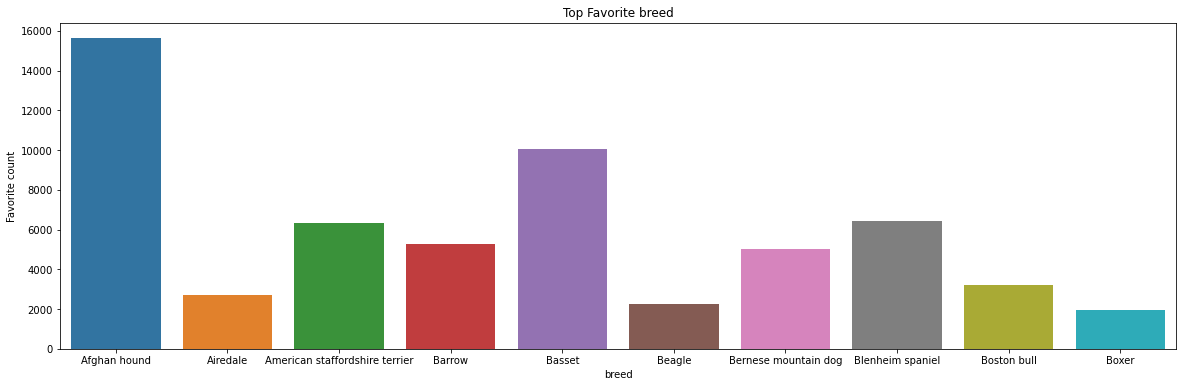

In [102]:
# Set the width and height of the figure
plt.figure(figsize=(20,6))

# Add title
plt.title("Top Favorite breed")

sns.barplot(x=analys_1.index, y=analys_1.favorite_count)

plt.ylabel("Favorite count")

In [103]:
analys_2=(analys_1.sort_values('retweet_count',ascending=False,na_position='last')).groupby(['breed']).mean().head(10)

Text(0, 0.5, 'Retweet count')

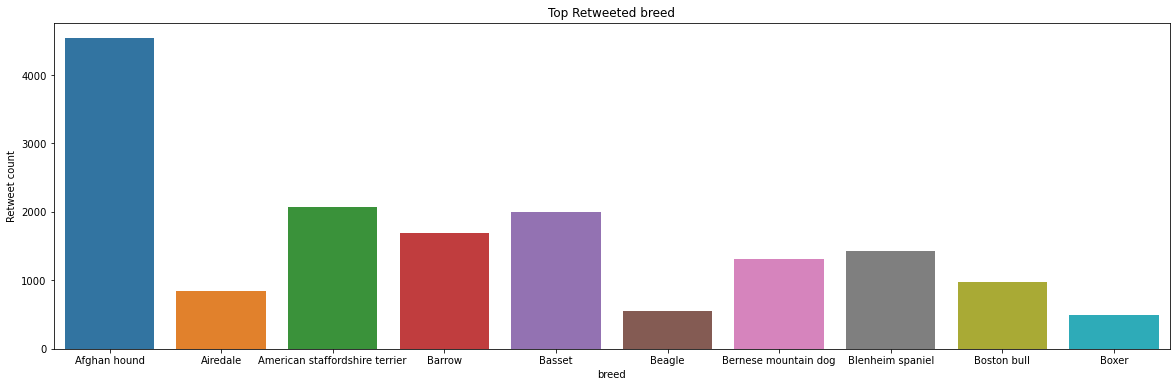

In [104]:
# Checking the top retweeted breed 
plt.figure(figsize=(20,6))

plt.title("Top Retweeted breed")

sns.barplot(x=analys_1.index, y=analys_1.retweet_count)

plt.ylabel("Retweet count")

In [105]:
#here I will check the top rating breed 
analys_3 =df_master.loc[(df_master['prediction_level'] == 1) & (df_master['prediction'] > .9),['rating_numerator','breed']]

In [106]:
analys_3=(analys_3.sort_values('rating_numerator',ascending=False,na_position='last')).groupby(['breed']).mean()

In [107]:
analys_3

,rating_numerator
breed,
Afghan hound,13.00
Airedale,10.50
American staffordshire terrier,11.50
Barrow,10.50
Basset,11.00
...,...
Vizsla,11.25
Web site,10.75
Weimaraner,10.00


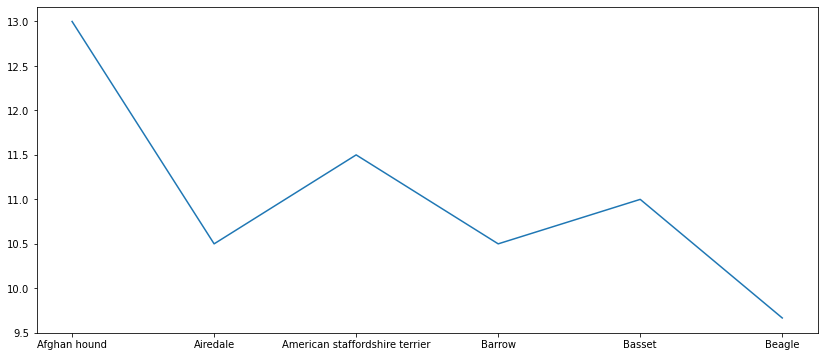

In [108]:
plt.figure(figsize=(14,6))

sns.lineplot(data=analys_3.rating_numerator.head(6));

In [109]:
#check the most common Dog_stage 
analys_4 = df_master.loc[(df_master['prediction_level'] == 1) & (df_master['prediction'] > .9),['dog_stage','breed']]

In [110]:
analys_4=analys_4.sort_values('dog_stage',ascending=False,na_position='last')

In [111]:
analys_4

,dog_stage,breed
33,puppo,Pembroke
858,puppo,American staffordshire terrier
1866,puppo,Labrador retriever
1833,puppo,Swing
1323,puppo,German shepherd
...,...,...
4803,NaN,Chihuahua
4842,NaN,German shepherd
4869,NaN,Blenheim spaniel
4878,NaN,Chihuahua


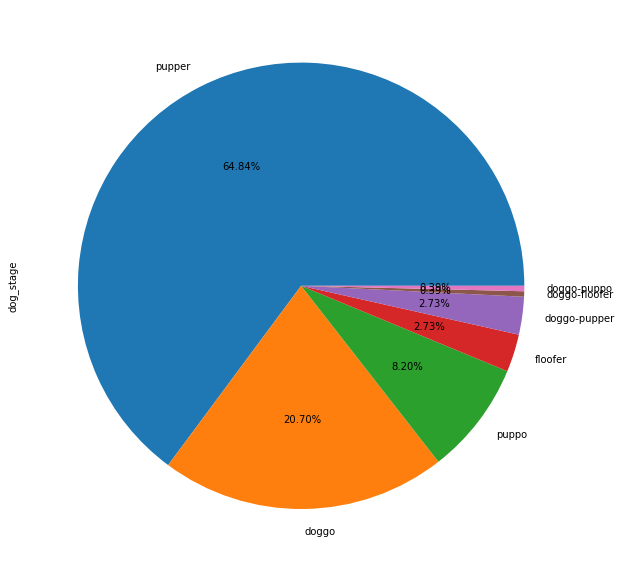

In [112]:
df_master['dog_stage'].value_counts().plot(kind='pie', autopct='%.2f%%', figsize=(10,20));

In [113]:
#here I will check the retweet count and favorite count over the time 
analys_5 = df_master

In [114]:
analys_5['timestamp'] = analys_5['timestamp'].str.slice(start=0, stop=-6)
analys_5['timestamp'] = pd.to_datetime(analys_5['timestamp'], format = "%Y-%m-%d %H:%M:%S")

In [115]:
analys_5['month'] = analys_5['timestamp'].dt.month

In [116]:
analys_5 = analys_5.loc[(df_master['prediction_level'] == 1) & (df_master['prediction'] > .9),['retweet_count','favorite_count','month']].head(20)

In [117]:
analys_5

,retweet_count,favorite_count,month
27,6565,28429,7
33,8962,44509,7
36,4006,25048,7
39,2022,14054,7
54,3111,20185,7
75,2837,19575,7
78,5662,25933,7
81,6024,30186,7
99,5108,25107,7
108,8852,42431,7


Text(0.5, 0, 'month')

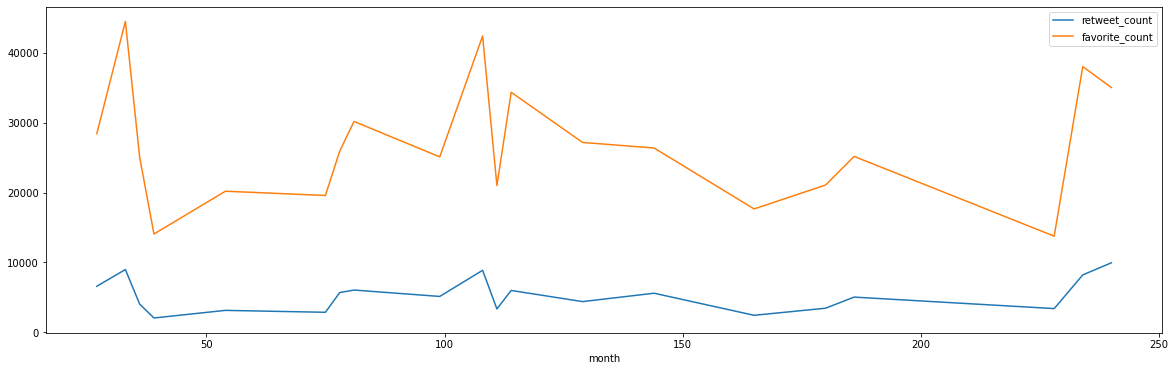

In [118]:
plt.figure(figsize=(20,6))

sns.lineplot(data=analys_5['retweet_count'], label="retweet_count")

sns.lineplot(data=analys_5['favorite_count'], label="favorite_count")

plt.xlabel("month")